# Example Workflow with spatial_data
Welcome to spatial_data! In this notebook, we will go through an example workflow by looking at the following steps:
1. Reading in a highly multiplexed image and creating a spatial_data object
2. Performing basic image processing steps to boost the signal-to-noise ratio
3. Performing cell segmentation using _StarDist_
4. Quantifying protein expression per cell
5. Predicting cell types with a simple argmax technique
6. Plotting the results

In [55]:
%load_ext autoreload
%autoreload 2

import spatial_data
from skimage.io import imread
import matplotlib.pyplot as plt

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# 1. Getting Started

Before we can get started with spatial_data, we first need to read in the image. This can be done with the _skimage_ or _tifffile_ libraries.

In [42]:
# reading in the image and displaying its shape
image = imread('../../data/input.tiff')
image.shape

(5, 500, 500)

We can see that our image has 5 channels and has a size of 500 by 500 pixels. Next, we want to create a spatial_data object and store the image within the object. To do this, we also need to feed in the names of the channels.

In [43]:
spatial_data_object = spatial_data.load_image_data(image, channel_coords=['DAPI', 'CD4', 'CD8', 'FOXP3', 'BCL6'])

`spatial_data.load_image_data` returns an xarray object that we can simply inspect by calling in an jupyter cell. Note that the image is stored as the data variable `_image`.

In [44]:
spatial_data_object

<xarray.Dataset>
Dimensions:   (channels: 5, y: 500, x: 500)
Coordinates:
  * channels  (channels) <U5 'DAPI' 'CD4' 'CD8' 'FOXP3' 'BCL6'
  * y         (y) int64 0 1 2 3 4 5 6 7 8 ... 492 493 494 495 496 497 498 499
  * x         (x) int64 0 1 2 3 4 5 6 7 8 ... 492 493 494 495 496 497 498 499
Data variables:
    _image    (channels, y, x) uint16 10816 12359 14504 10965 ... 147 129 149 59

# 2. Image Processing
Highly multiplexed fluorescence imaging techniques frequently suffer from poor signal-to-noise ratio. To alleviate this problem, you can filter out low intensity pixels, thereby boosting the contrast of the image. While there are automated methods to determine the thresholds for such operations, it is difficult to come up with one that works in all cases. Here, we therefore set the thresholds based on manual inspection.

Let's start by looking at the data set in the current form.

utils.py (494): The return type of `Dataset.dims` will be changed to return a set of dimension names in future, in order to be more consistent with `DataArray.dims`. To access a mapping from dimension names to lengths, please use `Dataset.sizes`.


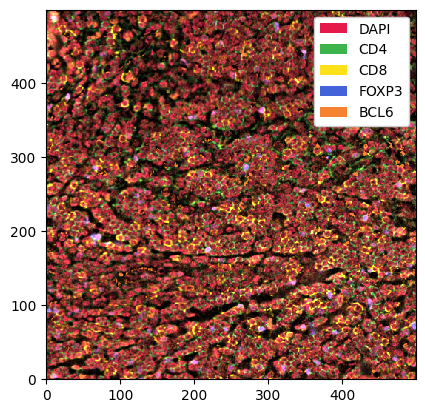

In [45]:
_ = spatial_data_object.pl.imshow()  # pl: the plotting module

This is a bit much to look at. First, we want to check only the DAPI channel, to get a feel for the signal-to-noise ratio.

utils.py (494): The return type of `Dataset.dims` will be changed to return a set of dimension names in future, in order to be more consistent with `DataArray.dims`. To access a mapping from dimension names to lengths, please use `Dataset.sizes`.


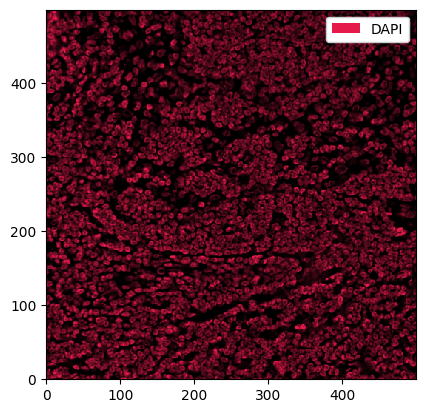

In [46]:
_ = spatial_data_object.pp['DAPI'].pl.imshow()  # we can use pp[channels] to subset the spatial_data_object

This looks promising. What about the other channels?

utils.py (494): The return type of `Dataset.dims` will be changed to return a set of dimension names in future, in order to be more consistent with `DataArray.dims`. To access a mapping from dimension names to lengths, please use `Dataset.sizes`.


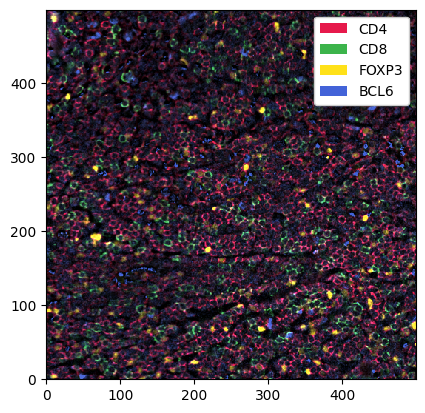

In [47]:
_ = spatial_data_object.pp[['CD4', 'CD8', 'FOXP3', 'BCL6']].pl.imshow() # pp: the preprocessing module

Looking good, but we can make the signal a bit clearer by performing some image processing. In the following codeblock, we first filter the channels by some percentile (so every value below that percentile gets set to 0). We then apply a 2D median filter with a kernel size of 3 to apply some smoothing.

In [48]:
# the percentiles by which the channels will be filtered
percentiles = [0.2, 0.6, 0.6, 0.6, 0.6]

# filtering and smoothing the data
spatial_data_object = spatial_data_object.pp.filter(percentiles).pp.restore('medfilt2d', kernel_size=3)

Let's plot the new object.

utils.py (494): The return type of `Dataset.dims` will be changed to return a set of dimension names in future, in order to be more consistent with `DataArray.dims`. To access a mapping from dimension names to lengths, please use `Dataset.sizes`.
utils.py (494): The return type of `Dataset.dims` will be changed to return a set of dimension names in future, in order to be more consistent with `DataArray.dims`. To access a mapping from dimension names to lengths, please use `Dataset.sizes`.


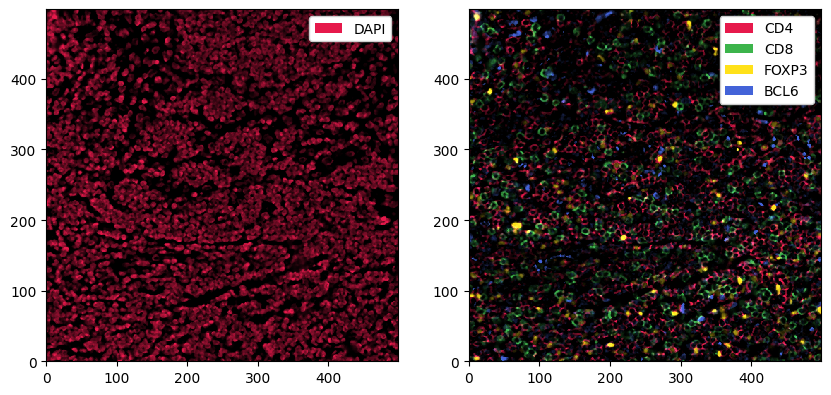

In [57]:
fig, ax = plt.subplots(1, 2, figsize=(10, 5))
_ = spatial_data_object.pp['DAPI'].pl.imshow(ax=ax[0])
_ = spatial_data_object.pp[['CD4', 'CD8', 'FOXP3', 'BCL6']].pl.imshow(ax=ax[1])

# 3. Cell Segmentation

Great, this is our preprocessing done. Next, we can perform cell segmentation. Since we only have a universal nuclear marker at hand (and no universal membrane marker), we will segment the nuclei and then simply extend the segmentation masks by two pixels in every direction. We are going to use _StarDist_ for this purpose, which is implemented in the external (ext) module.

In [58]:
spatial_data_object = spatial_data_object.ext.stardist()

Found model '2D_versatile_fluo' for 'StarDist2D'.


2024-05-07 14:33:48.472108: W tensorflow/core/common_runtime/gpu/gpu_device.cc:2251] Cannot dlopen some GPU libraries. Please make sure the missing libraries mentioned above are installed properly if you would like to use GPU. Follow the guide at https://www.tensorflow.org/install/gpu for how to download and setup the required libraries for your platform.
Skipping registering GPU devices...


Loading network weights from 'weights_best.h5'.
Loading thresholds from 'thresholds.json'.
Using default values: prob_thresh=0.479071, nms_thresh=0.3.


100%|██████████| 144/144 [00:59<00:00,  2.43it/s]
Found disconnected masks in the segmentation.
Kept largest component of each disconnected cell.
Found disconnected masks in the segmentation.
Kept largest component of each disconnected cell.
Found centroid-0 in _obs. Skipping.
Found centroid-1 in _obs. Skipping.


Looking at the object, you will realize that a new layer called `_segmentation` has appeared.

In [59]:
spatial_data_object

<xarray.Dataset>
Dimensions:        (channels: 5, y: 500, x: 500, cells: 3257, features: 2)
Coordinates:
  * channels       (channels) <U5 'DAPI' 'CD4' 'CD8' 'FOXP3' 'BCL6'
  * y              (y) int64 0 1 2 3 4 5 6 7 ... 492 493 494 495 496 497 498 499
  * x              (x) int64 0 1 2 3 4 5 6 7 ... 492 493 494 495 496 497 498 499
  * cells          (cells) int64 1 2 3 4 5 6 7 ... 3252 3253 3254 3255 3256 3257
  * features       (features) <U10 'centroid-0' 'centroid-1'
Data variables:
    _image         (channels, y, x) float64 0.0 9.602e+03 9.69e+03 ... 0.0 0.0
    _segmentation  (y, x) int64 3201 3201 3201 0 0 0 0 ... 3127 3127 0 0 0 0 0
    _obs           (cells, features) float64 190.8 183.4 318.8 ... 221.9 430.5

We can plot this segmentation over the DAPI channel to see what exactly _StarDist_ did. We can zoom in a little bit to get a clearer picture.

utils.py (494): The return type of `Dataset.dims` will be changed to return a set of dimension names in future, in order to be more consistent with `DataArray.dims`. To access a mapping from dimension names to lengths, please use `Dataset.sizes`.


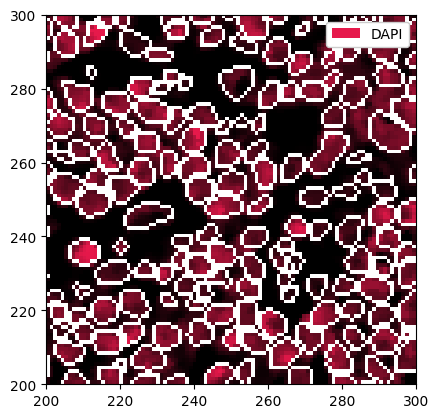

In [61]:
_ = spatial_data_object.pp['DAPI'].pp[200:300, 200:300].pl.imshow(render_segmentation=True)


There are two issues with the current masks. One is that _StarDist_ tends to segment very small cells, which are likely artifacts. We can hence filter cells that are too small or too big. In addition, we will grow the masks by two pixels in each direction to try to capture cytosole and membrane.

Found _obs in image container. Concatenating.
utils.py (494): The return type of `Dataset.dims` will be changed to return a set of dimension names in future, in order to be more consistent with `DataArray.dims`. To access a mapping from dimension names to lengths, please use `Dataset.sizes`.


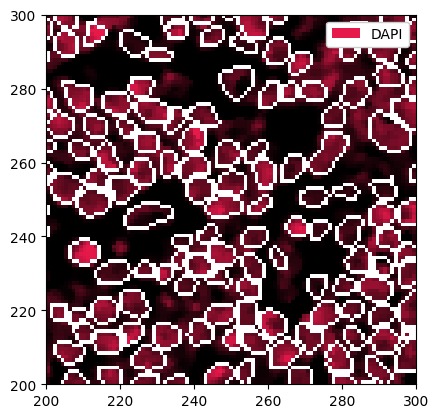

In [70]:
# filtering out cells with less than 20 or more than 150 pixels
spatial_data_object = spatial_data_object.pp.add_observations("area").pp.filter_by_obs('area', func=lambda x: (x > 20) & (x < 150))
# plotting the result
_ = spatial_data_object.pp['DAPI'].pp[200:300, 200:300].pl.imshow(render_segmentation=True)

In [72]:
# expanding the masks
spatial_data_object = spatial_data_object.pp.grow_cells(iterations=2)

Found disconnected masks in the segmentation.


Kept largest component of each disconnected cell.
Mask growing requires recalculation of the observations. All features other than the centroids will be removed and should be recalculated with pp.add_observations().


utils.py (494): The return type of `Dataset.dims` will be changed to return a set of dimension names in future, in order to be more consistent with `DataArray.dims`. To access a mapping from dimension names to lengths, please use `Dataset.sizes`.
utils.py (494): The return type of `Dataset.dims` will be changed to return a set of dimension names in future, in order to be more consistent with `DataArray.dims`. To access a mapping from dimension names to lengths, please use `Dataset.sizes`.


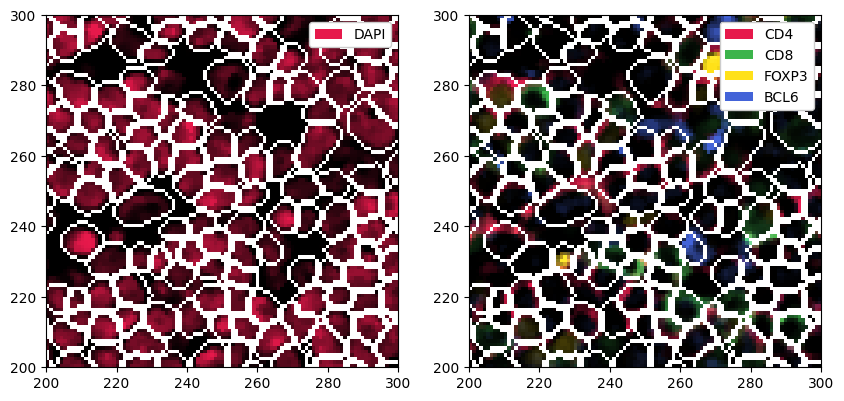

In [74]:
# plotting the resulting segmentation masks
fig, ax = plt.subplots(1, 2, figsize=(10, 5))
_ = spatial_data_object.pp['DAPI'].pp[200:300, 200:300].pl.imshow(render_segmentation=True, ax=ax[0])
_ = spatial_data_object.pp[['CD4', 'CD8', 'FOXP3', 'BCL6']].pp[200:300, 200:300].pl.imshow(render_segmentation=True, ax=ax[1])

# 4. Quantifying Protein Expression per Cell
Now that we have sensible segmentation masks, we can quantify the protein expression in each cell. There are multiple ways to do this, but taking the median intensity and then applying an arcsinh-transform has been proven to work pretty well.

In [79]:
spatial_data_object = spatial_data_object.pp.add_quantification(func=spatial_data.pp.arcsinh_mean_intensity)
spatial_data_object

<xarray.Dataset>
Dimensions:        (channels: 5, y: 500, x: 500, cells: 2831, features: 2)
Coordinates:
  * channels       (channels) <U5 'DAPI' 'CD4' 'CD8' 'FOXP3' 'BCL6'
  * y              (y) int64 0 1 2 3 4 5 6 7 ... 492 493 494 495 496 497 498 499
  * x              (x) int64 0 1 2 3 4 5 6 7 ... 492 493 494 495 496 497 498 499
  * cells          (cells) int64 1 2 3 4 5 6 7 ... 2826 2827 2828 2829 2830 2831
  * features       (features) <U10 'centroid-0' 'centroid-1'
Data variables:
    _image         (channels, y, x) float64 0.0 9.602e+03 9.69e+03 ... 0.0 0.0
    _segmentation  (y, x) int64 2811 2811 2811 2811 2811 2811 ... 0 0 0 0 0 0
    _obs           (cells, features) float64 190.3 183.2 318.6 ... 221.8 430.9
    _intensity     (cells, channels) float64 7.77 4.132 7.992 ... 4.674 3.461

As you can see, this introduced a new layer called `_intensity`. We can now use this to predict cell types.

# 5. Cell Type Prediction
There are several ways to predict cell types. Since we filtered our data beforehand, we can simply take the argmax of the cell type specific channels to get an idea of the cell types we are looking at. Methods related to cell type prediction are all implemented in the label (la) module.

In [81]:
# this dictionary maps from cell types to markers
marker_dict = {'T_h': 'CD4', 'T_tox': 'CD8', 'T_reg': 'FOXP3', 'T_fh': 'BCL6'}
spatial_data_object = spatial_data_object.la.predict_cell_types_argmax(marker_dict)

In [82]:
spatial_data_object

<xarray.Dataset>
Dimensions:        (labels: 4, props: 2, channels: 5, y: 500, x: 500,
                    cells: 2831, features: 3)
Coordinates:
  * labels         (labels) int64 1 2 3 4
  * props          (props) <U6 '_color' '_name'
  * channels       (channels) <U5 'DAPI' 'CD4' 'CD8' 'FOXP3' 'BCL6'
  * y              (y) int64 0 1 2 3 4 5 6 7 ... 492 493 494 495 496 497 498 499
  * x              (x) int64 0 1 2 3 4 5 6 7 ... 492 493 494 495 496 497 498 499
  * cells          (cells) int64 1 2 3 4 5 6 7 ... 2826 2827 2828 2829 2830 2831
  * features       (features) <U10 '_labels' 'centroid-0' 'centroid-1'
Data variables:
    _labels        (labels, props) object '#372101' 'T_fh' ... '#A77500' 'T_tox'
    _image         (channels, y, x) float64 0.0 9.602e+03 9.69e+03 ... 0.0 0.0
    _segmentation  (y, x) int64 2811 2811 2811 2811 2811 2811 ... 0 0 0 0 0 0
    _obs           (cells, features) float64 4.0 190.3 183.2 ... 2.0 221.8 430.9
    _intensity     (cells, channels) float64 7.77 4.132 7.992 ... 4.674 3.461

This added a couple of things. For one, `_obs` now contains a feature called `_labels`. Furthermore, the `_labels` layer assigns each cell type to a color, which can be useful for plotting.

# 6. Plotting
Finally, let's do some plotting of the predicted cell types next to the markers. Before plotting, we can set some colors for the cell types (labels).

In [87]:
# setting the colors for the cell types
spatial_data_object = spatial_data_object.la.set_label_colors(['T_h', 'T_tox', 'T_reg', 'T_fh'], ['red', 'green', 'yellow', 'blue'])

utils.py (494): The return type of `Dataset.dims` will be changed to return a set of dimension names in future, in order to be more consistent with `DataArray.dims`. To access a mapping from dimension names to lengths, please use `Dataset.sizes`.


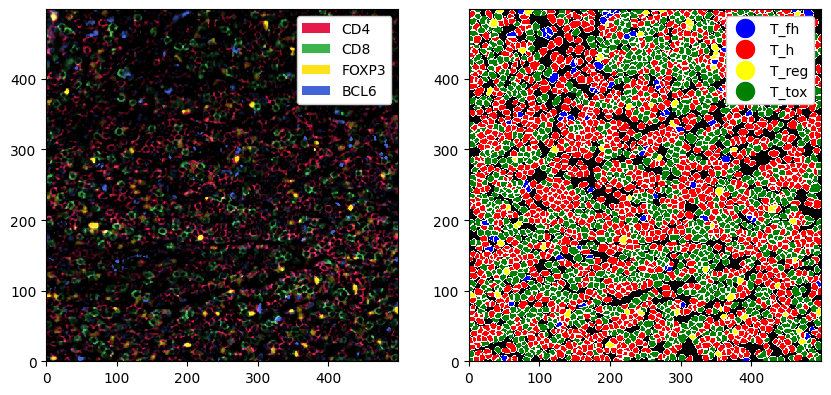

In [92]:
fig, ax = plt.subplots(1, 2, figsize=(10, 5))
_ = spatial_data_object.pp[['CD4', 'CD8', 'FOXP3', 'BCL6']].pl.imshow(ax=ax[0])
_ = spatial_data_object.pl.imshow(render_intensities=False, render_segmentation=True, render_labels=True, ax=ax[1])

And this is how easy it can be to perform analysis of highly multiplexed immunofluorescence images! If you have any additional questions, check out the other notebooks for details.